# DATA ANALYSIS COUNT

In [1]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap
import numpy as np
import re
import json
import csv
import matplotlib.pyplot as plt


In [2]:
# model=word2vec.Word2Vec.load('../Data/Models/word2vec_epoch_1000_min_1.model')
#model=word2vec.Word2Vec.load('../Data/Models/best_model.model')
model=word2vec.Word2Vec.load('../Data/Models/best_model_new.model') #dim 300 mange gange med adressesammensmeltning
#model=word2vec.Word2Vec.load('../Data/Models/best_model_100_dim_5e.model')

In [3]:
f = open('../Data/data.json')
data = json.load(f)

a = open('../Data/added_data.json')
added_data = json.load(a)

In [4]:
with open('../Data/sequences.csv', 'r') as f:
    reader = csv.reader(f)
    sequences = list(reader)

In [5]:
X = model.wv.vectors

In [6]:
# tsne
def tsne_plot(X):
    X=np.array(X)
    #pca = PCA(n_components=50)
    #X_pca=pca.fit_transform(X)
    proj = TSNE(perplexity=20).fit_transform(X)
    return proj
proj=tsne_plot(X)

# UMAP 
proj_1 = umap.UMAP(n_components=2, n_neighbors=20, metric='cosine').fit_transform(X)

# pca 
pca = PCA(n_components=2)
proj_2=pca.fit_transform(X)

In [44]:
# pacmap 
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_3 = embedding.fit_transform(X, init="pca")


In [8]:
# Create a dictionary to map addresses to their corresponding embeddings
journey_embeddings = {}
for journey in sequences:
    for place in journey:
        try:
            journey_id = place  # Convert the journey list to a tuple to use as a dictionary key
            journey_embeddings[journey_id] = model.wv[journey_id]
        except KeyError:
            # Handle cases where the journey is not present in the Word2Vec model
            pass

# Convert dictionary to numpy array
X = np.array(list(journey_embeddings.values()))

# Create a list of all addresses
journey_ids = list(journey_embeddings.keys())

# Create a dictionary mapping addresses to their index in the numpy array
journey_idx = {journey_id: idx for idx, journey_id in enumerate(journey_ids)}

In [9]:
print(len(journey_ids)) #number of unique locations is 3751

3751



____________________________________________________________________________________________________________________________________________________



















# Cosine similarity

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming X is your embeddings_matrix
embeddings_matrix = X.shape

# Calculate cosine similarity matrix between station vectors
similarity_matrix = cosine_similarity(X)

highest = -1
for i in range(similarity_matrix.shape[0]):
    for j in range(similarity_matrix.shape[1]):
        if i != j and similarity_matrix[i, j] > highest:
            highest = similarity_matrix[i, j]

print(highest)

# Find the indices of the maximum similarity score in the updated matrix
max_indices = np.argwhere(similarity_matrix == highest)

# Extract the indices of the most similar pair
most_similar_pair_indices = max_indices[0]

# Get the station names corresponding to the indices
station_names = model.wv.index_to_key
station_i_name = station_names[most_similar_pair_indices[0]]
station_j_name = station_names[most_similar_pair_indices[1]]

# Print the names of the two most similar stations
print(f"The two most similar stations (not the same) are: {station_i_name} and {station_j_name}")


# # X is your numpy array containing the embedding vectors. Each row of X represents a vector in the embedding space.
# # cosine_similarity(X) computes the cosine similarity between all pairs of vectors in X.
# # The resulting similarity_matrix is a symmetric matrix where each element similarity_matrix[i, j] represents the cosine similarity between vectors X[i] and X[j].
# # After calculating the cosine similarity matrix, you can proceed to perform clustering or any other analysis based on the similarity values.

0.99548227
The two most similar stations (not the same) are: C.M. Larsens Alle and Syrefabriksvej


In [ ]:
for seq in sequences:
    if 'Syrefabriksvej' in seq:
        print(seq)

print()

for seq in sequences:
    if 'C.M. Larsens Alle' in seq:
        print(seq)

In [ ]:
def find_similar(test): 
    similar_locations = model.wv.most_similar(test, topn=4000)
    similarity_map = {}  # Dictionary to store address-similarity pairs
    for address, similarity_score in similar_locations: 
        similarity_map[address] = similarity_score
    return similarity_map

### København H

In [ ]:
from collections import Counter

# Initialize a Counter object to count station occurrences
station_counter = Counter()

# Iterate over sequences and count stations that appear together with 'København H'
for seq in sequences:
    if 'København H' in seq:
        for station in seq:
            # Skip 'København H' itself
            if station != 'København H':
                station_counter[station] += 1

# Print the station counts
for station, count in sorted(station_counter.items()):
    print(f"{station}: {count}")

# Validation of embeddingspace
The paper validates the emdeddingspace shown by doing some similarity tests

In [ ]:
find_similar('København H')

In [ ]:
find_similar('CPH Lufthavn')

In [ ]:
find_similar('Syrefabriksvej')

In [ ]:
find_similar('C.M. Larsens Alle')

In [35]:
cph_lufthavn_index = journey_idx['CPH Lufthavn']

similarity_scores_with_cph_lufthavn = similarity_matrix[cph_lufthavn_index]

# Create a map of addresses to similarity scores with 'CPH Lufthavn'
addresses_similarity_map = {}
for i, score in enumerate(similarity_scores_with_cph_lufthavn):
    address = journey_ids[i]
    addresses_similarity_map[address] = score

sorted_addresses_similarity = dict(sorted(addresses_similarity_map.items(), key=lambda item: item[1], reverse=True))

# Print the similarity scores of all addresses with 'CPH Lufthavn'
for address, similarity_score in sorted_addresses_similarity.items():
    print(f"Similarity score between 'CPH Lufthavn' and '{address}': {similarity_score}")

Similarity score between 'CPH Lufthavn' and 'CPH Lufthavn': 0.9999997019767761
Similarity score between 'CPH Lufthavn' and 'Kastrup Tværvej B': 0.3608551323413849
Similarity score between 'CPH Lufthavn' and 'Clarion Hotel Copenhagen Airport': 0.3446331322193146
Similarity score between 'CPH Lufthavn' and 'Terminalvej Airside': 0.3296213746070862
Similarity score between 'CPH Lufthavn' and 'Kastrup St. (Metro)': 0.30767735838890076
Similarity score between 'CPH Lufthavn' and 'Vestvej': 0.3003397285938263
Similarity score between 'CPH Lufthavn' and 'Kastrup Tværvej F': 0.2994389832019806
Similarity score between 'CPH Lufthavn' and 'Ellehammersvej': 0.29619017243385315
Similarity score between 'CPH Lufthavn' and 'Lufthavnstorvet': 0.29348453879356384
Similarity score between 'CPH Lufthavn' and 'Københavns Lufthavn': 0.2907196879386902
Similarity score between 'CPH Lufthavn' and 'Terminalgade': 0.29054930806159973
Similarity score between 'CPH Lufthavn' and 'Kastrup Tværvej C': 0.289829462

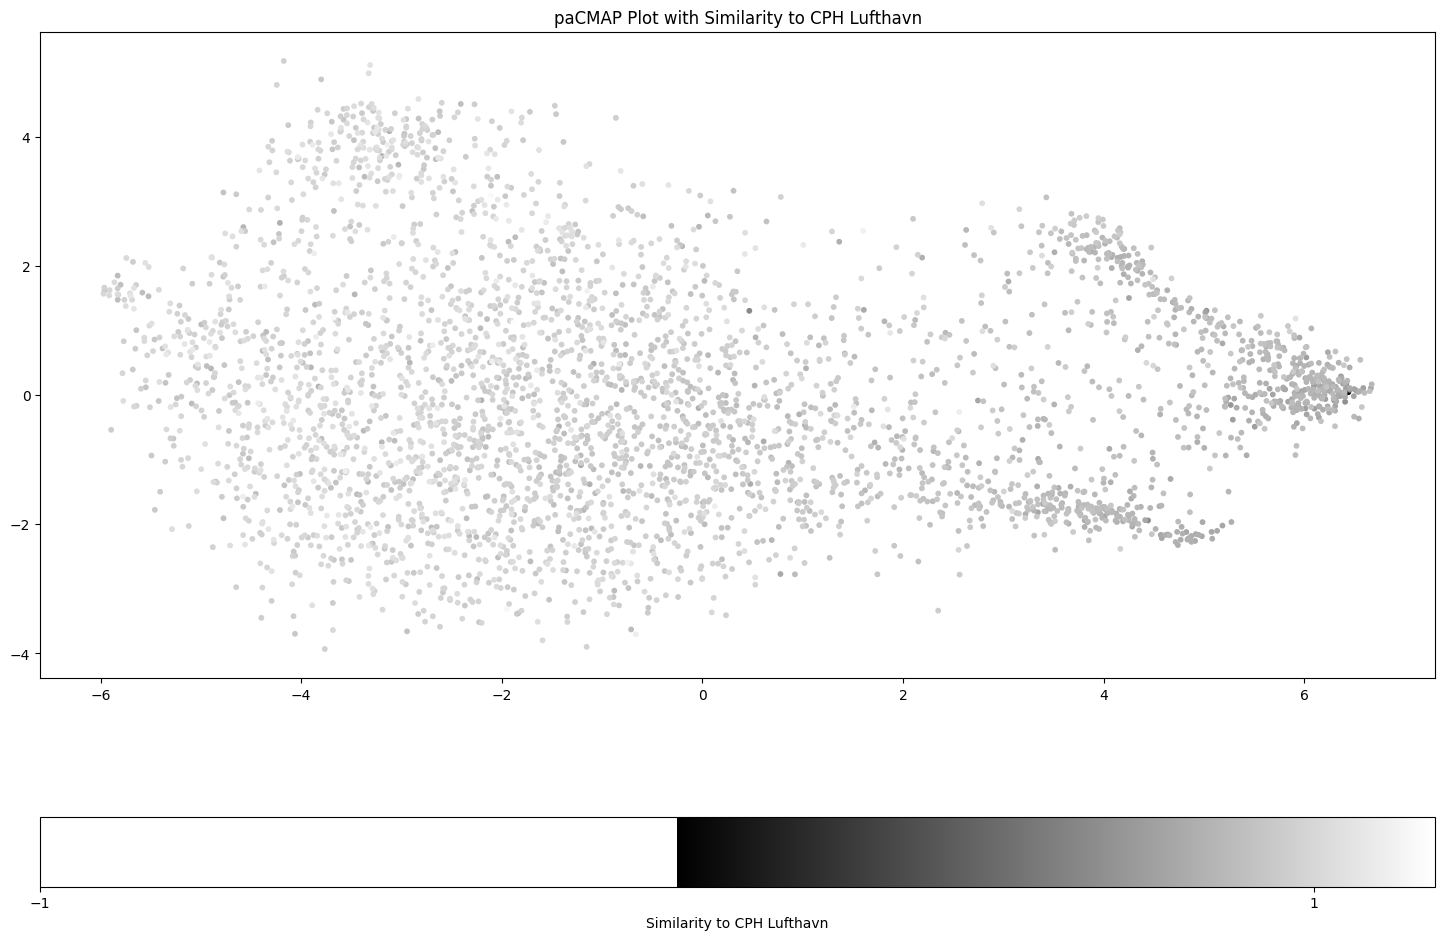

In [52]:
import matplotlib.pyplot as plt
from pacmap import PaCMAP
from sklearn.metrics.pairwise import cosine_similarity

station_names = sorted_addresses_similarity.keys()

# Map the similarity scores to grayscale values
grayscale_values = [(1 - sorted_addresses_similarity[station]) for station in station_names]

fig, ax = plt.subplots(1,1, figsize=(18,12))
# Plot the stations using paCMAP with grayscale colors
scatter = plt.scatter(proj_3[:, 0], proj_3[:, 1], c=grayscale_values, cmap='gray', s=10)
cbar = plt.colorbar(scatter, label='Similarity to CPH Lufthavn', orientation='horizontal')
cbar.set_ticks([-1,1])
plt.title('paCMAP Plot with Similarity to CPH Lufthavn')
plt.show()


In [55]:
kbh_index = journey_idx['København H']

similarity_scores_with_kbh = similarity_matrix[kbh_index]

# Create a map of addresses to similarity scores with 'CPH Lufthavn'
addresses_similarity_map_kbh = {}
for i, score in enumerate(similarity_scores_with_kbh):
    address = journey_ids[i]
    addresses_similarity_map_kbh[address] = score

sorted_addresses_similarity_kbh = dict(sorted(addresses_similarity_map_kbh.items(), key=lambda item: item[1], reverse=True))

for address, similarity_score in sorted_addresses_similarity_kbh.items():
    print(f"Similarity score between 'København H' and '{address}': {similarity_score}")

Similarity score between 'København H' and 'København H': 1.000000238418579
Similarity score between 'København H' and 'København H (Metro)': 0.41252821683883667
Similarity score between 'København H' and 'Rådhuspladsen': 0.37930670380592346
Similarity score between 'København H' and 'Rådhuspladsen St.': 0.3579707741737366
Similarity score between 'København H' and 'Bernstorffsgade': 0.3288237452507019
Similarity score between 'København H' and 'Vesterport St.': 0.32287490367889404
Similarity score between 'København H' and 'Glyptoteket': 0.31820032000541687
Similarity score between 'København H' and 'Polititorvet': 0.2834121286869049
Similarity score between 'København H' and 'Planetariet': 0.2793343663215637
Similarity score between 'København H' and 'Vesterbrogade': 0.2737448811531067
Similarity score between 'København H' and 'Davids Samling': 0.2718372941017151
Similarity score between 'København H' and 'Nørreport St.': 0.2645086348056793
Similarity score between 'København H' and

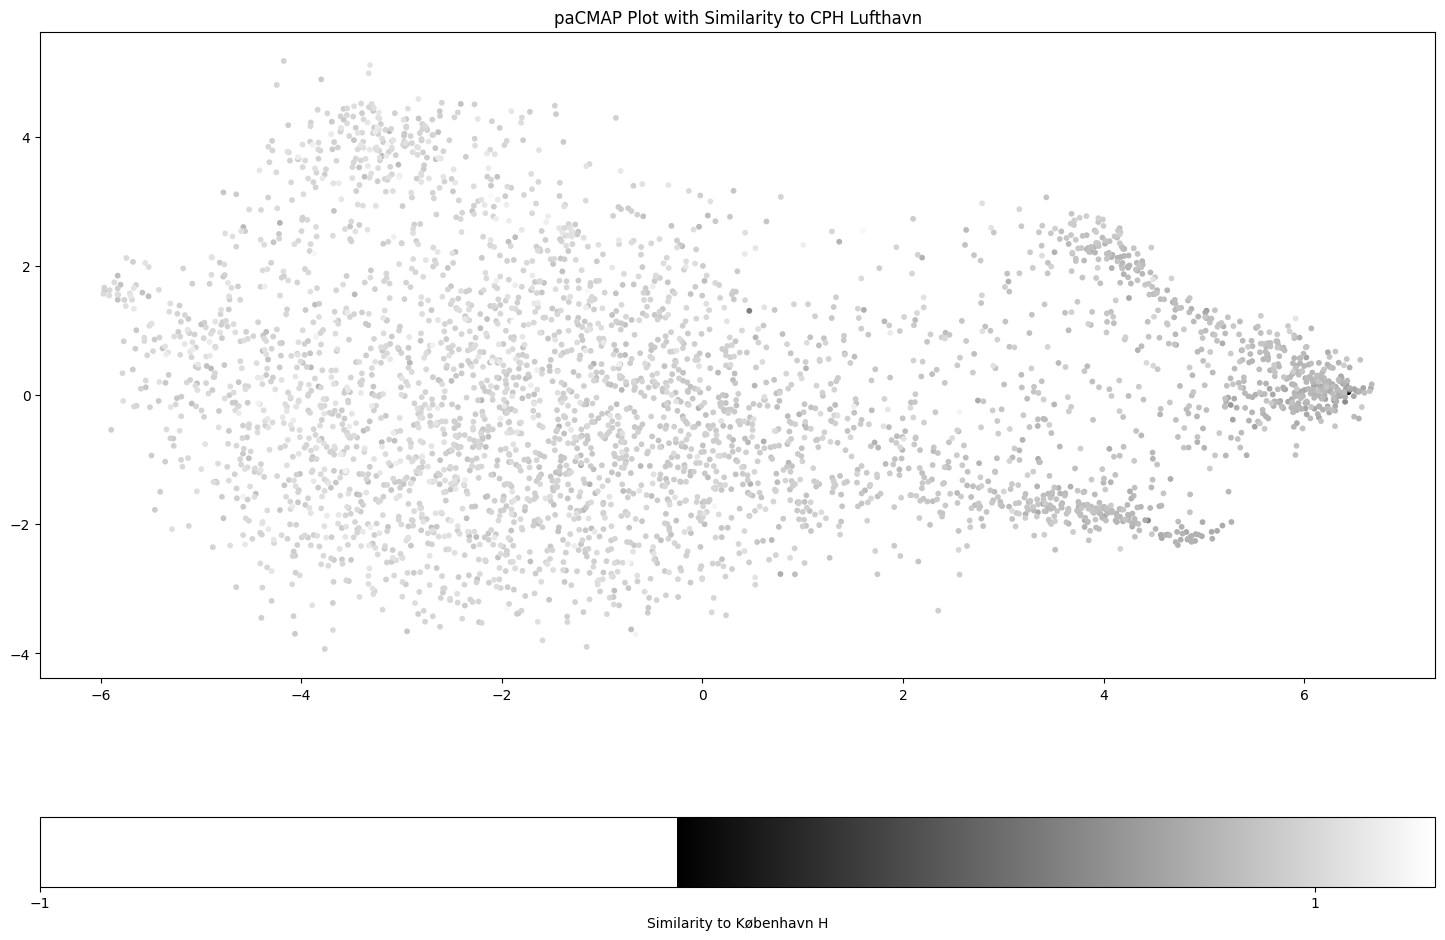

In [56]:
import matplotlib.pyplot as plt
from pacmap import PaCMAP
from sklearn.metrics.pairwise import cosine_similarity

station_names = sorted_addresses_similarity_kbh.keys()

# Map the similarity scores to grayscale values
grayscale_values = [(1 - sorted_addresses_similarity_kbh[station]) for station in station_names]

fig, ax = plt.subplots(1,1, figsize=(18,12))
# Plot the stations using paCMAP with grayscale colors
scatter = plt.scatter(proj_3[:, 0], proj_3[:, 1], c=grayscale_values, cmap='gray', s=10)
cbar = plt.colorbar(scatter, label='Similarity to København H', orientation='horizontal')
cbar.set_ticks([-1,1])
plt.title('paCMAP Plot with Similarity to København H')
plt.show()
